In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

import os
Images_Tumor_pfad = '/content/drive/My Drive/MRI_Images_Tumor'
Images_Tumor_Folder = os.listdir(Images_Tumor_pfad)

Masks_Tumor_pfad = '/content/drive/My Drive/processed_tumor_masks'
Masks_Tumor_Folder = os.listdir(Masks_Tumor_pfad)


Mounted at /content/drive


In [2]:
pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 35.2 MB/s eta 0:00:00


# **Imports**

In [3]:
import os
import cv2
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from PIL import Image

**Testings and Experiments on one example Image**

In [4]:
# Path to your folder
img_path = '/content/drive/My Drive/MRI_Images_Tumor/00045_20990909_L_CC_1.dcm'
mask_path = '/content/drive/My Drive/processed_tumor_masks/00045_20990909_L_CC_1_mask_processed.png'


Load the image and mask

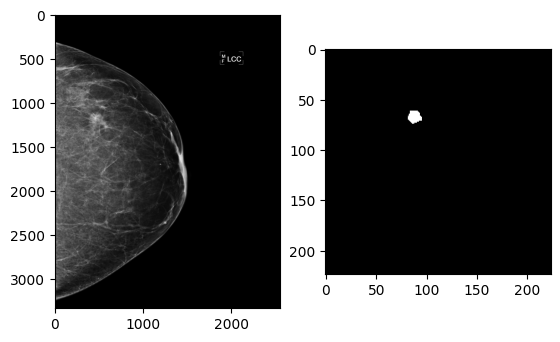

In [12]:
ds = pydicom.dcmread(img_path)
orig_img = ds.pixel_array
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

plt.subplot(1,2,1)
plt.imshow(orig_img, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(mask, cmap='gray')
plt.show()

Divide all individual preprocessing steps into functions; Cropping, Resizing, Padding

In [6]:
def crop_image(image):
  old_size = image.shape[:2]

  if len(image.shape) == 3:
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  else:
      gray_image = image

  _, thresh = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY)
  thresh = thresh.astype(np.uint8)

  contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  min_contour_area = 1000
  filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]
  if len(filtered_contours) > 0:
      # Find the largest contour
      largest_contour = max(filtered_contours, key=cv2.contourArea)
      x, y, w, h = cv2.boundingRect(largest_contour)
      bbox = (x, y, w, h)
      cropped = image[y:y+h, x:x+w]

      return cropped, bbox, old_size, cropped.shape  # Return both image and bbox
  return None,None,None, None  # In case no contour is found, return the image and None for bbox


def resize_image(image, target_size=(224, 224)):
    # Check if image is of uint8 type
    if image.dtype != np.uint8:
        image = ((image - np.min(image)) / (np.max(image) - np.min(image)) * 255).astype(np.uint8)

    old_size = image.shape[:2]  # Get current size (height, width)

    # Calculate the resizing ratio based on the target size
    ratio = min(target_size[1] / old_size[1], target_size[0] / old_size[0])

    # Calculate the new size
    new_size = tuple([int(x * ratio) for x in old_size])

    # Resize the image while maintaining aspect ratio
    resized_image = cv2.resize(image, (new_size[1], new_size[0]))

    return resized_image, new_size, ratio

def pad_image(resized_image, target_size=(224, 224)):
    # Get the size of the resized image
    resized_height, resized_width = resized_image.shape[:2]

    # Calculate the padding needed to reach the target size
    delta_w = int(target_size[1] - resized_width)
    delta_h = int(target_size[0] - resized_height)

    # Calculate padding for top, bottom, left, and right
    top, bottom = int(delta_h // 2), int(delta_h - (delta_h // 2))
    left, right = int(delta_w // 2), int(delta_w - (delta_w // 2))

    padding = (top, bottom, left, right)

    # Add padding using cv2.copyMakeBorder
    if len(resized_image.shape) == 2:
        padded_image = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)
    else:
        padded_image = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    return padded_image, padding


Visualize the output of each preprocessing function

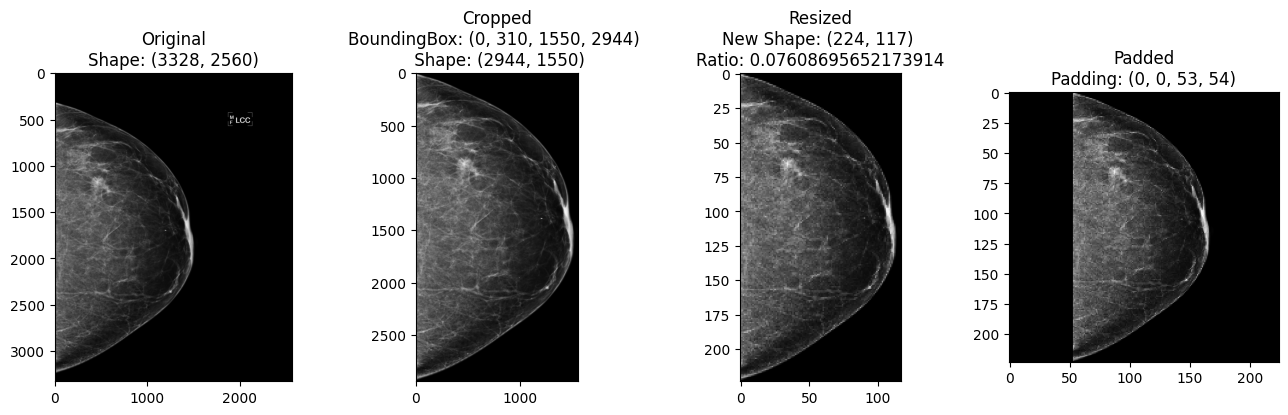

In [7]:
cropped,bbox,old_size, cropped_shape = crop_image(orig_img)
resize, new_size, ratio = resize_image(cropped)
padded, padding = pad_image(resize)
plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.imshow(orig_img, cmap='gray')
plt.title("Original\nShape: " + str(orig_img.shape))


plt.subplot(1, 4, 2)
plt.imshow(cropped, cmap='gray')
plt.title(f"Cropped\nBoundingBox: {bbox} \n Shape: {cropped_shape}")

plt.subplot(1, 4, 3)
plt.imshow(resize, cmap='gray')
plt.title(f"Resized\nNew Shape: {new_size} \nRatio: {ratio}")


plt.subplot(1, 4, 4)
plt.imshow(padded, cmap='gray')
plt.title("Padded\nPadding: " + str(padding))

plt.show()

In [8]:
# Postprocessing function that reverses the steps of the preprocessing
def postprocess_mask(padded_image, padding, original_size, bbox, cropped_shape, target_size=(224, 224)):

    # Step 1: Extract the padding values (top, bottom, left, right) and the original image size
    top, bottom, left, right = padding
    original_height, original_width = original_size

    # Step 2: Remove the padding from the image
    image_without_padding = padded_image[top:target_size[0] - bottom, left:target_size[1] - right]

    # Step 3: Resize the image based on the input aspect ratio to match the cropped shape
    image_height, image_width = image_without_padding.shape[:2]
    cropped_height, cropped_width = cropped_shape

    # Resize the image to fit within the cropped shape (keeping aspect ratio)
    resized_image = cv2.resize(image_without_padding, (cropped_width, cropped_height), interpolation=cv2.INTER_LINEAR)

    # Step 4: Place the resized image into the expanded canvas based on the bounding box
    x, y, w, h = bbox

    # Create an empty canvas for the restored image (of the original size)
    expanded_image = np.zeros((original_height, original_width), dtype=np.uint8)

    # Ensure that we place the resized cropped region back into the correct location in the original image
    expanded_image[y:y+h, x:x+w] = resized_image[:h, :w]  # Make sure the resized image fits in the bounding box area

    return image_without_padding, resized_image, expanded_image


In [9]:
image_without_padding, restored_image, expanded_image = postprocess_mask(padded, padding, old_size, bbox, cropped_shape)

Visualize postprocessing steps

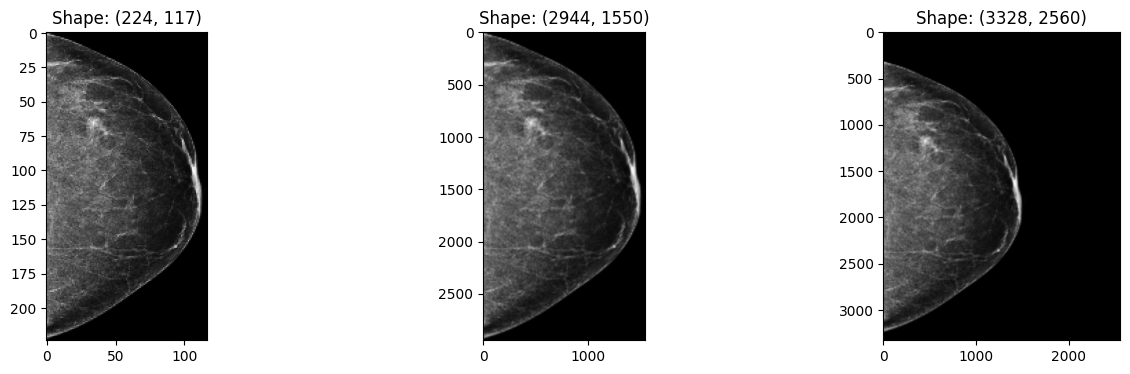

In [10]:
plt.figure(figsize=(16, 4))
plt.subplot(1,3,1)
plt.imshow(image_without_padding, cmap='gray')
plt.title("Shape: " + str(image_without_padding.shape))
plt.subplot(1,3,2)
plt.imshow(restored_image, cmap='gray')
plt.title("Shape: " + str(restored_image.shape))
plt.subplot(1,3,3)
plt.imshow(expanded_image, cmap='gray')
plt.title("Shape: " + str(expanded_image.shape))
plt.show()


Postprocess the GT mask

In [13]:
cropped,bbox,old_size, cropped_shape = crop_image(orig_img)
resize, new_size, ratio = resize_image(cropped)
padded, padding = pad_image(resize)

_,_,post_mask = postprocess_mask(mask, padding, orig_img.shape, bbox, cropped_shape)

Visualize preprocessed image and annotation and postprocessed image and annotation

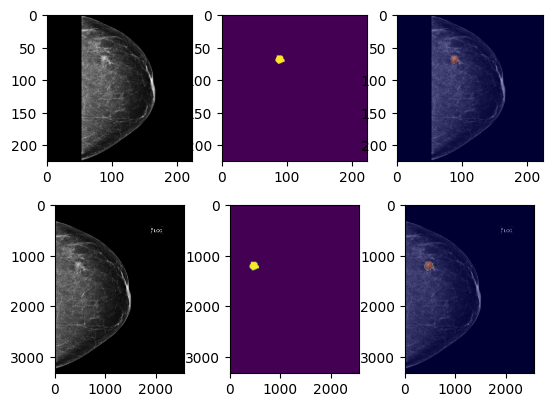

In [14]:
plt.subplot(2,3,1)
plt.imshow(padded, cmap="gray")
plt.subplot(2,3,2)
plt.imshow(mask)
plt.subplot(2,3,3)
plt.imshow(padded, cmap="gray")
plt.imshow(mask, cmap="jet", alpha=0.4)
plt.subplot(2,3,4)
plt.imshow(orig_img, cmap="gray")
plt.subplot(2,3,5)
plt.imshow(post_mask)
plt.subplot(2,3,6)
plt.imshow(orig_img, cmap="gray")
plt.imshow(post_mask, cmap="jet", alpha=0.4)